In [1]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
from keras.utils import to_categorical

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# 🤙Create helper functions

In [2]:
import urllib.request

# URL of the helper_functions.py file
url = 'https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py'

# Specify the local path to save the downloaded file
local_path = 'helper_functions.py'

# Download the file
urllib.request.urlretrieve(url, local_path)

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

In [4]:
# Walk through each directory
dataset = "data\\raw-data"
walk_through_dir(dataset)

There are 47 directories and 1 images in 'data\raw-data'.
There are 0 directories and 74 images in 'data\raw-data\Adho Mukha Svanasana'.
There are 0 directories and 65 images in 'data\raw-data\Adho Mukha Vrksasana'.
There are 0 directories and 18 images in 'data\raw-data\Alanasana'.
There are 0 directories and 71 images in 'data\raw-data\Anjaneyasana'.
There are 0 directories and 59 images in 'data\raw-data\Ardha Chandrasana'.
There are 0 directories and 96 images in 'data\raw-data\Ardha Matsyendrasana'.
There are 0 directories and 13 images in 'data\raw-data\Ardha Navasana'.
There are 0 directories and 54 images in 'data\raw-data\Ardha Pincha Mayurasana'.
There are 0 directories and 12 images in 'data\raw-data\Ashta Chandrasana'.
There are 0 directories and 81 images in 'data\raw-data\Baddha Konasana'.
There are 0 directories and 84 images in 'data\raw-data\Bakasana'.
There are 0 directories and 79 images in 'data\raw-data\Balasana'.
There are 0 directories and 94 images in 'data\raw-

In [5]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Create a DataFrame for labels
labels_df = pd.DataFrame(labels, columns=['Label'])

# Save the DataFrame to a CSV file
labels_df.to_csv('labels_final.csv', index=False)

In [6]:
image_df
labels_df

Label
0     Adho Mukha Svanasana
1           Ardha Navasana
2          Baddha Konasana
3          Baddha Konasana
4          Baddha Konasana
...                    ...
4705             Vrksasana
4706             Vrksasana
4707             Vrksasana
4708             Vrksasana
4709             Vrksasana

[4710 rows x 1 columns]

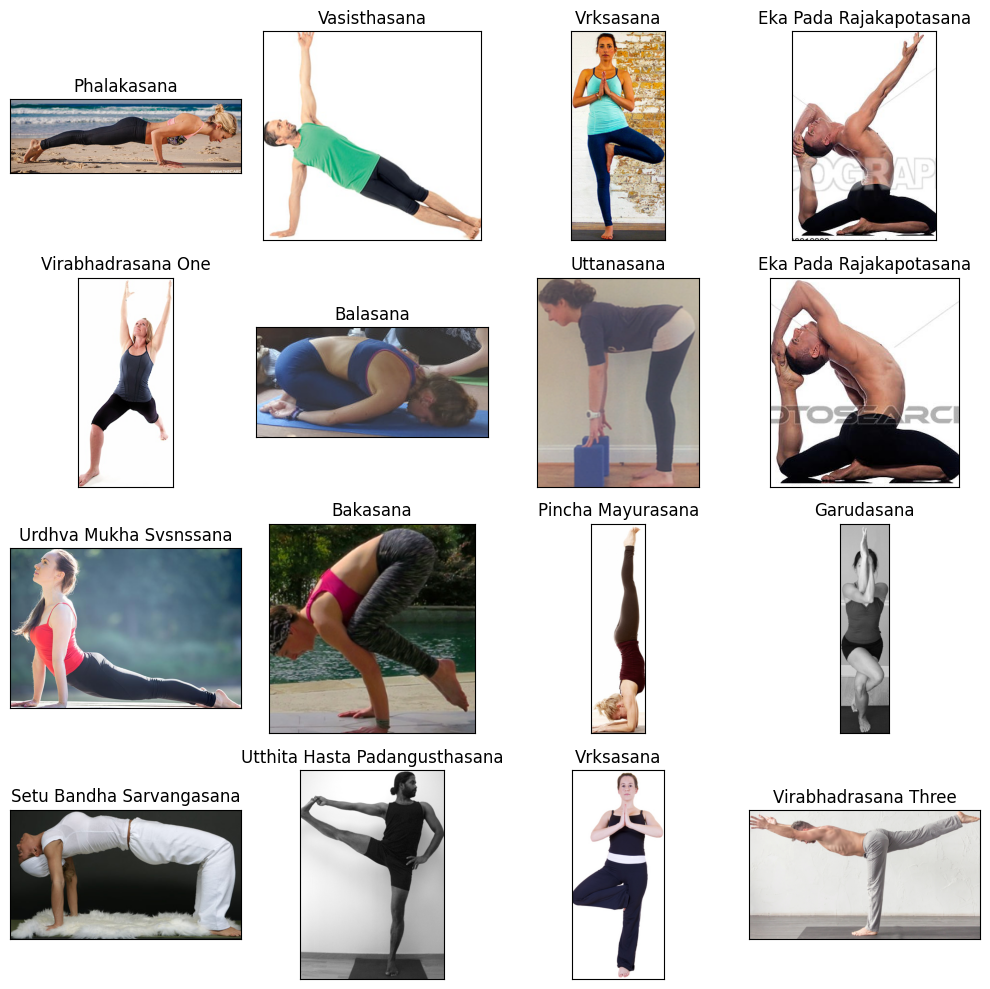

In [7]:
# Display 9 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [8]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')
        
    items = list(items)
        
    p = random.choice(items)
    return p.as_posix()

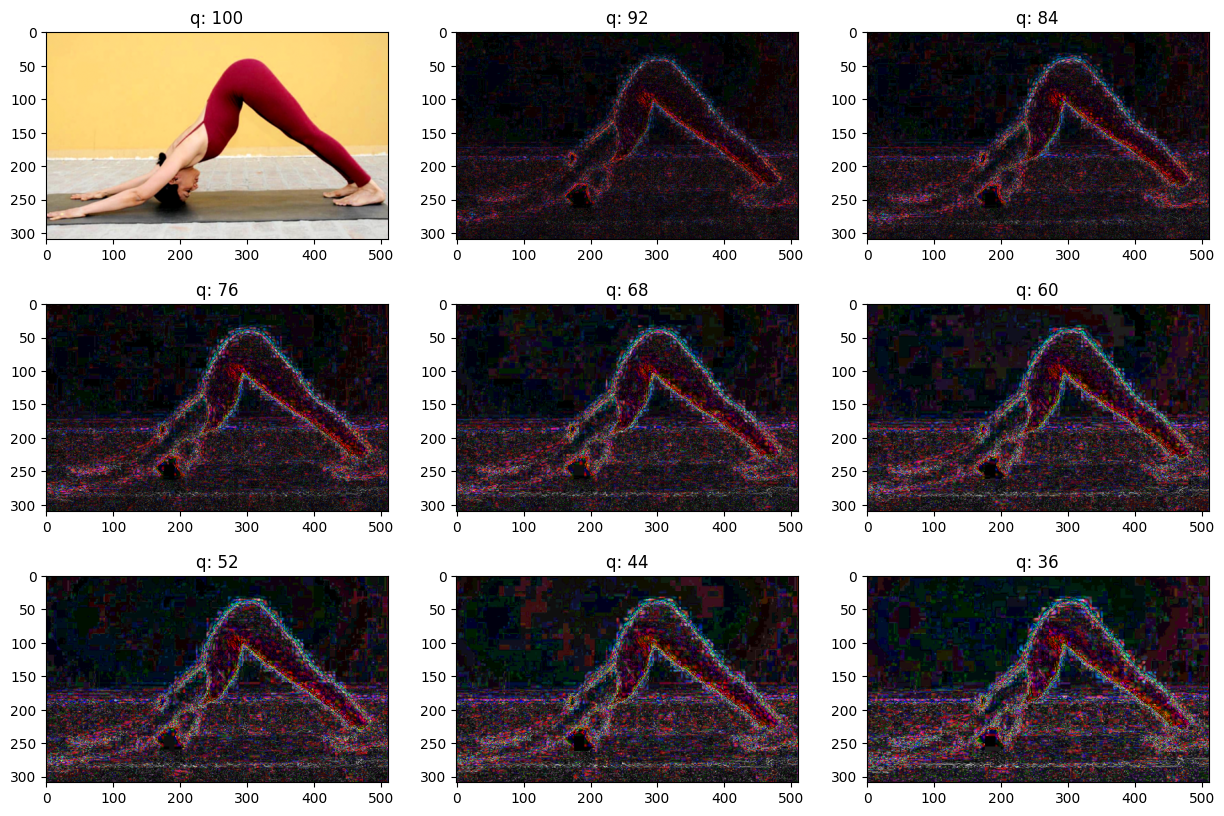

In [9]:
# View random sample from the dataset
p = random_sample('data\\raw-data\\Adho Mukha Svanasana')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i) 
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

In [10]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.01, shuffle=True, random_state=1)

In [11]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input,
    validation_split=0.1
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input
)

In [12]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 4196 validated image filenames belonging to 43 classes.
Found 466 validated image filenames belonging to 43 classes.
Found 48 validated image filenames belonging to 29 classes.


In [13]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# Setup data augmentation
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal_and_vertical"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),                       
], name="data_augmentation")

In [14]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [15]:
# Create checkpoint callback
checkpoint_path = "yoga_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [16]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3,
                                                  restore_best_weights=True) # if val loss decreases for 3 epochs in a row, stop training

# 🚄Train the model

In [17]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)
x = data_augmentation(x)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(43, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=50,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "yoga_classification"),
        checkpoint_callback,
    ]
)
model.save('my_model_final.h5')

Saving TensorBoard log files to: training_logs/yoga_classification/20230913-130314
Epoch 1/50
 42/132 [========>.....................] - ETA: 51s - loss: 3.4400 - accuracy: 0.1019

c:\Users\cardo\Documents\edrich\project_optel\myenv\Lib\site-packages\PIL\Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


132/132 [==============================] - 98s 681ms/step - loss: 2.5702 - accuracy: 0.2936 - val_loss: 1.2548 - val_accuracy: 0.6910
Epoch 2/50
132/132 [==============================] - 85s 641ms/step - loss: 1.0048 - accuracy: 0.7050 - val_loss: 0.7142 - val_accuracy: 0.8240
Epoch 3/50
132/132 [==============================] - 83s 627ms/step - loss: 0.5604 - accuracy: 0.8298 - val_loss: 0.4411 - val_accuracy: 0.9056
Epoch 4/50
132/132 [==============================] - 84s 631ms/step - loss: 0.3202 - accuracy: 0.9092 - val_loss: 0.3515 - val_accuracy: 0.8948
Epoch 5/50
132/132 [==============================] - 88s 664ms/step - loss: 0.2246 - accuracy: 0.9388 - val_loss: 0.2448 - val_accuracy: 0.9356
Epoch 6/50
132/132 [==============================] - 90s 677ms/step - loss: 0.1794 - accuracy: 0.9476 - val_loss: 0.2462 - val_accuracy: 0.9421
Epoch 7/50
132/132 [==============================] - 89s 672ms/step - loss: 0.1470 - accuracy: 0.9588 - val_loss: 0.1759 - val_accuracy: 0.9

c:\Users\cardo\Documents\edrich\project_optel\myenv\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:

#results = model.evaluate(test_images, verbose=0)

#print("    Test Loss: {:.5f}".format(results[0]))
#print("Test Accuracy: {:.2f}%".format(results[1] * 100))

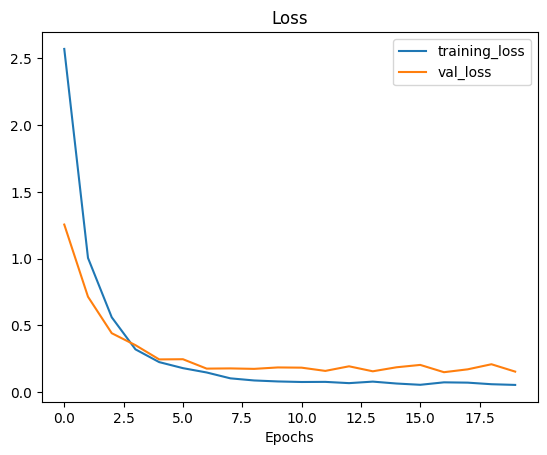

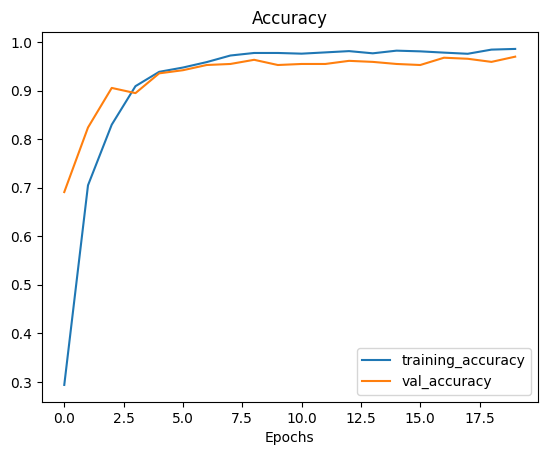

In [19]:
plot_loss_curves(history)

In [20]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

2/2 [==============================] - 2s 237ms/step
The first 5 predictions: ['Halasana', 'Adho Mukha Svanasana', 'Utkatasana', 'Malasana', 'Salamba Bhujangasana']


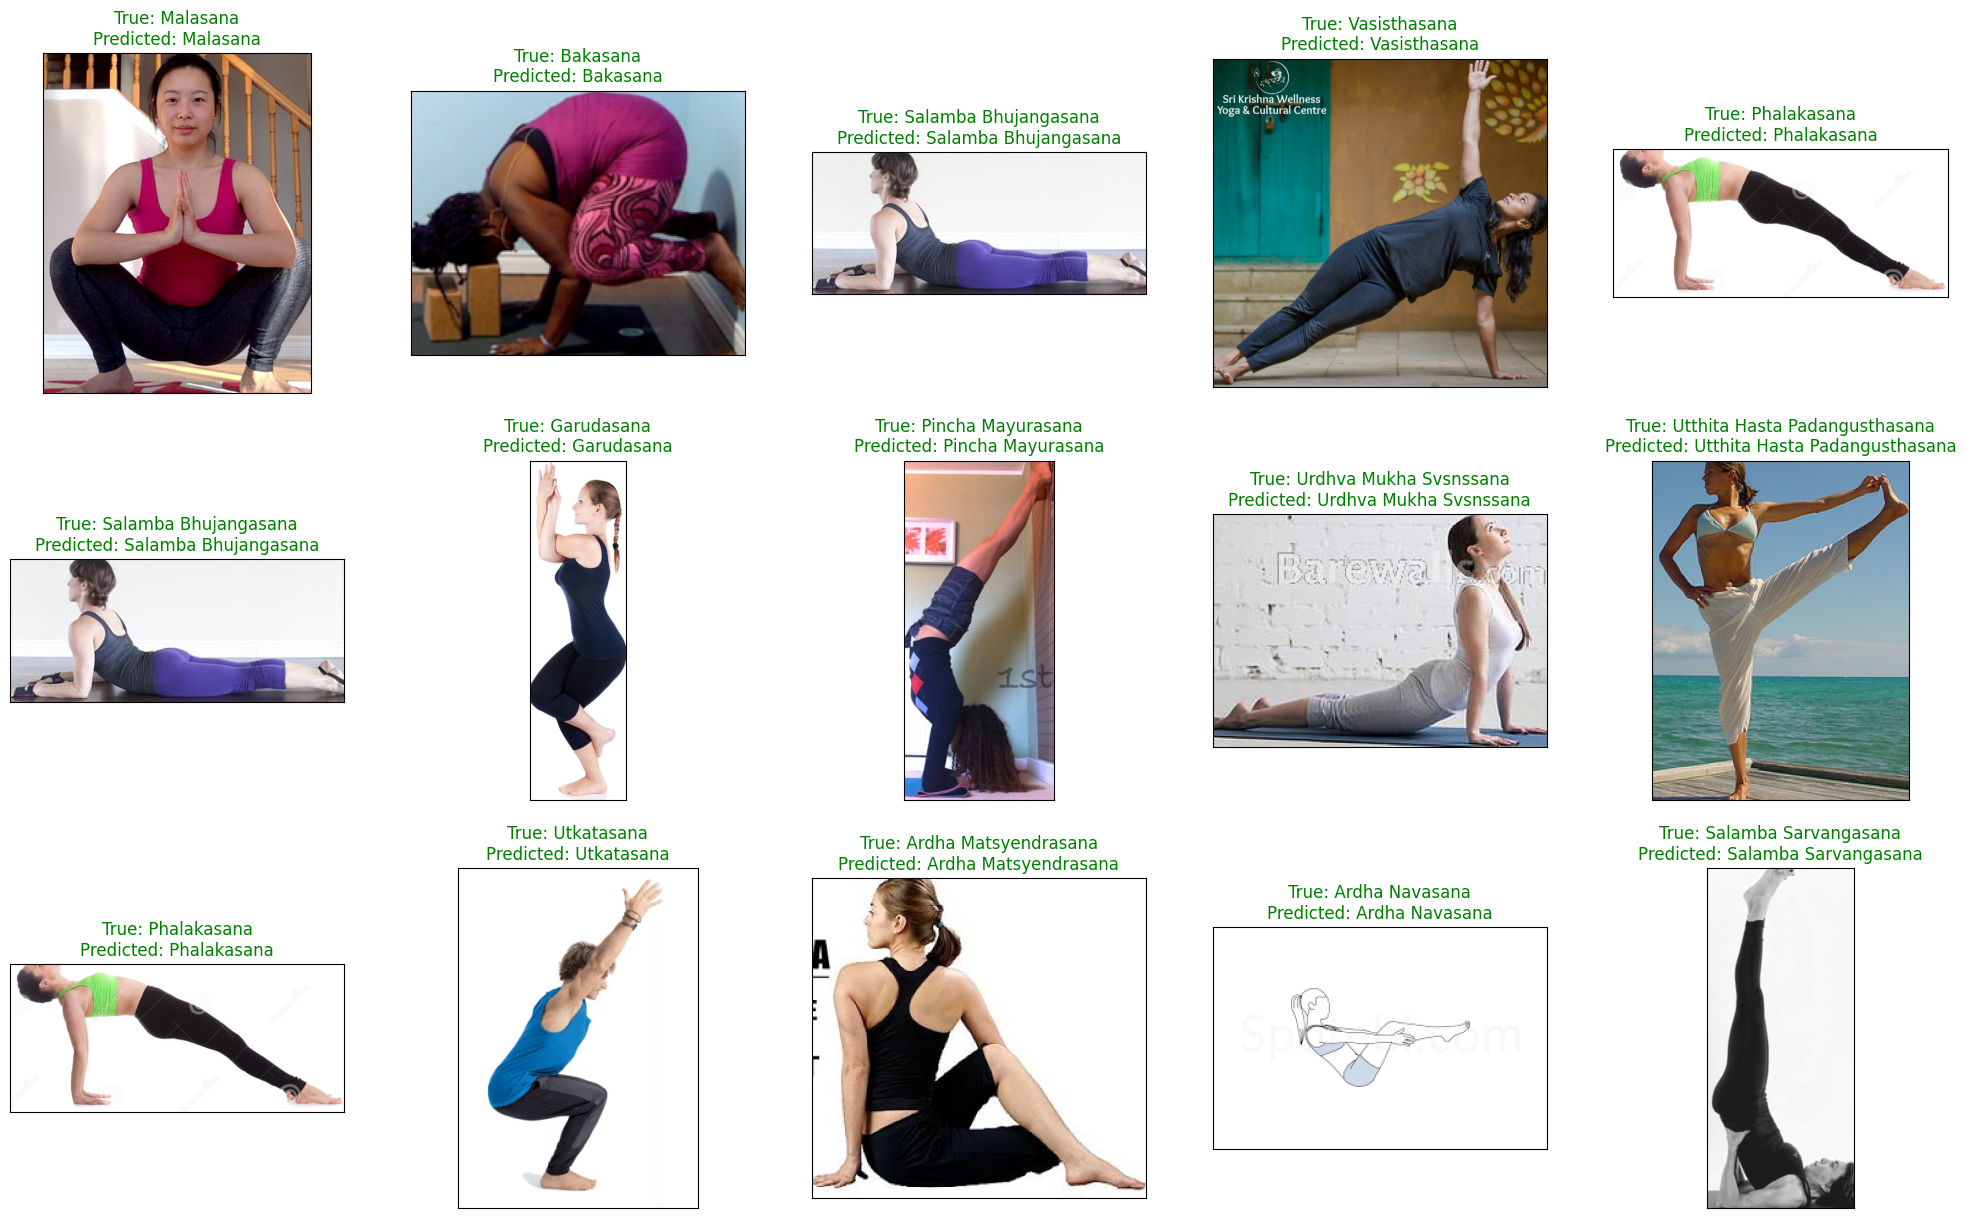

<Figure size 640x480 with 0 Axes>

In [39]:
  # Display 15 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [22]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                               precision    recall  f1-score   support

         Adho Mukha Svanasana       1.00      1.00      1.00         1
         Adho Mukha Vrksasana       1.00      1.00      1.00         1
            Ardha Chandrasana       0.00      0.00      0.00         0
         Ardha Matsyendrasana       1.00      1.00      1.00         1
               Ardha Navasana       1.00      1.00      1.00         1
      Ardha Pincha Mayurasana       1.00      1.00      1.00         2
              Baddha Konasana       1.00      1.00      1.00         1
                     Bakasana       1.00      1.00      1.00         2
                     Balasana       0.00      0.00      0.00         1
                   Bitilasana       1.00      1.00      1.00         2
      Eka Pada Rajakapotasana       1.00      1.00      1.00         1
                   Garudasana       1.00      1.00      1.00         4
                     Halasana       1.00      1.00      1.00         3
     

c:\Users\cardo\Documents\edrich\project_optel\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\cardo\Documents\edrich\project_optel\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\cardo\Documents\edrich\project_optel\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_st

In [23]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

c:\Users\cardo\Documents\edrich\project_optel\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\cardo\Documents\edrich\project_optel\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\cardo\Documents\edrich\project_optel\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_st

precision    recall  f1-score    support
Adho Mukha Svanasana            1.000000  1.000000  1.000000   1.000000
Adho Mukha Vrksasana            1.000000  1.000000  1.000000   1.000000
Ardha Chandrasana               0.000000  0.000000  0.000000   0.000000
Ardha Matsyendrasana            1.000000  1.000000  1.000000   1.000000
Ardha Navasana                  1.000000  1.000000  1.000000   1.000000
Ardha Pincha Mayurasana         1.000000  1.000000  1.000000   2.000000
Baddha Konasana                 1.000000  1.000000  1.000000   1.000000
Bakasana                        1.000000  1.000000  1.000000   2.000000
Balasana                        0.000000  0.000000  0.000000   1.000000
Bitilasana                      1.000000  1.000000  1.000000   2.000000
Eka Pada Rajakapotasana         1.000000  1.000000  1.000000   1.000000
Garudasana                      1.000000  1.000000  1.000000   4.000000
Halasana                        1.000000  1.000000  1.000000   3.000000
Hanumanasana                    1.000000  1.000000  1.000000   1.000000
Malasana                        1.000000  1.000000  1.000000   3.000000
Marjaryasana                    1.000000  1.000000  1.000000   1.000000
Phalakasana                     1.000000  1.000000  1.000000   2.000000
Pincha Mayurasana               1.000000  1.000000  1.000000   2.000000
Salamba Bhujangasana            1.000000  1.000000  1.000000   2.000000
Salamba Sarvangasana            1.000000  1.000000  1.000000   1.000000
Setu Bandha Sarvangasana        1.000000  1.000000  1.000000   1.000000
Urdhva Dhanurasana              1.000000  1.000000  1.000000   2.000000
Urdhva Mukha Svsnssana          1.000000  1.000000  1.000000   2.000000
Ustrasana                       1.000000  1.000000  1.000000   1.000000
Utkatasana                      0.666667  1.000000  0.800000   2.000000
Utthita Hasta Padangusthasana   1.000000  1.000000  1.000000   1.000000
Vasisthasana                    1.000000  1.000000  1.000000   3.000000
Virabhadrasana One              1.000000  1.000000  1.000000   1.000000
Virabhadrasana Three            1.000000  0.500000  0.666667   2.000000
Vrksasana                       1.000000  1.000000  1.000000   1.000000
accuracy                        0.958333  0.958333  0.958333   0.958333
macro avg                       0.922222  0.916667  0.915556  48.000000
weighted avg                    0.965278  0.958333  0.956944  48.000000

In [24]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))
    
    return cam_path
    

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "Conv_1"
img_size = (224,224, 3)

# Remove last layer's softmax
model.layers[-1].activation = None

C:\Users\cardo\AppData\Local\Temp\ipykernel_10032\2718660915.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


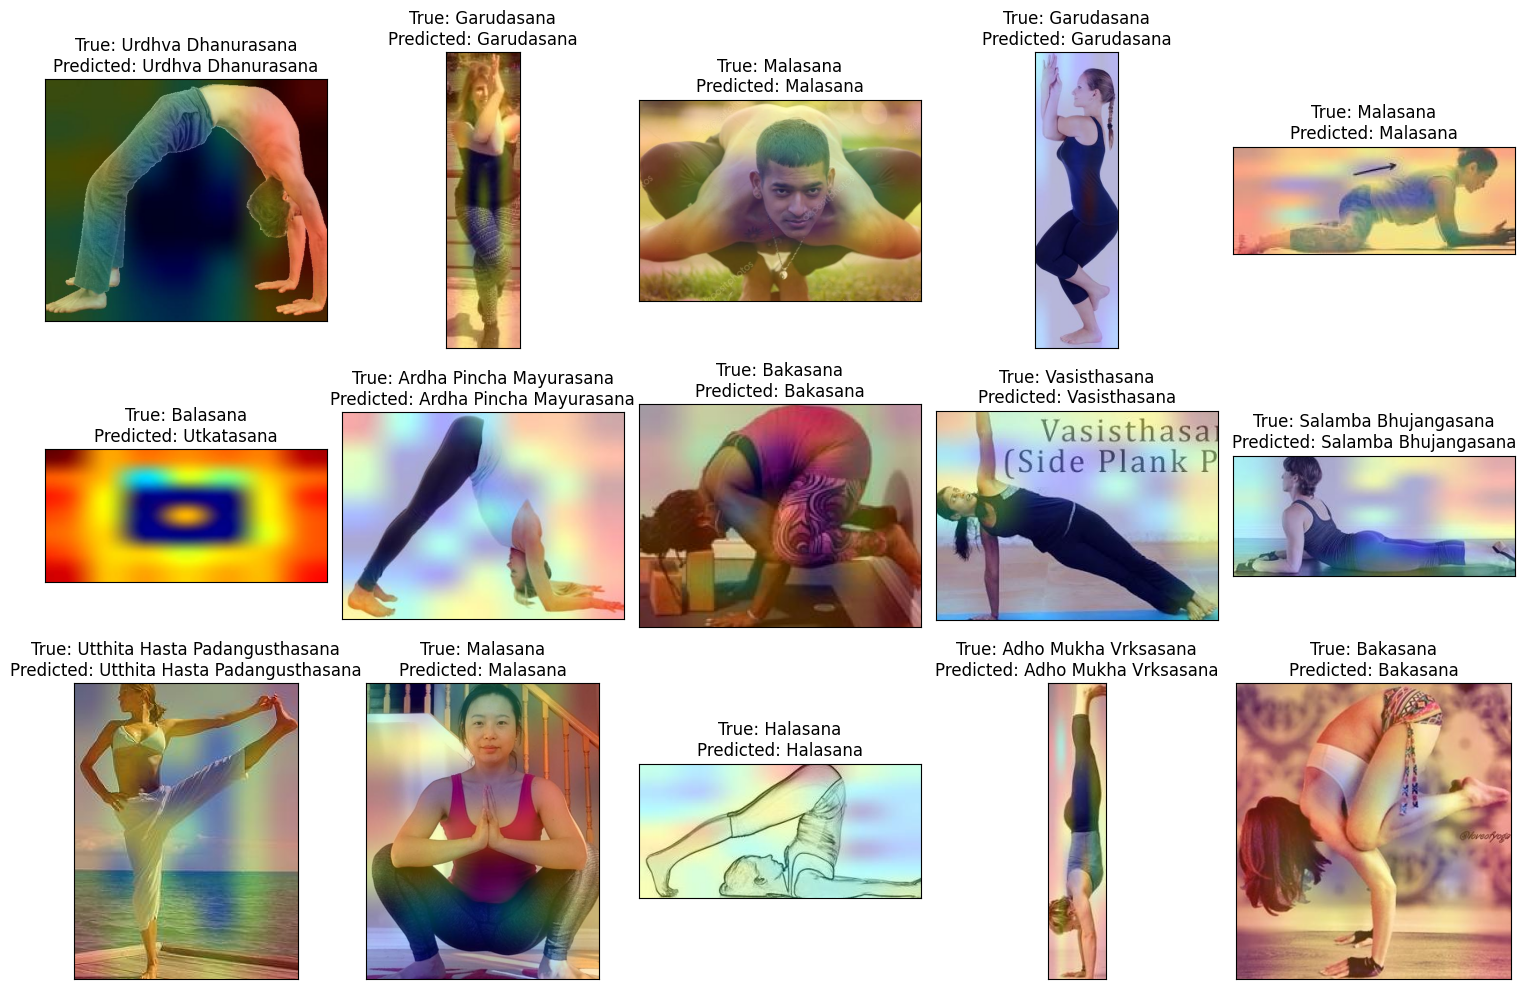

In [25]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}")
plt.tight_layout()
plt.show()

In [6]:
import os

# Define the path to the 'data/raw-data' folder
raw_data_folder = os.path.join('data', 'raw-data')

# Create a list to store the subfolder names and a label mapping dictionary
subfolder_names = []
label_mapping = {}

# Check if the 'raw-data' folder exists
if os.path.exists(raw_data_folder) and os.path.isdir(raw_data_folder):
    # List subfolders in 'raw-data'
    subfolder_names = [folder for folder in os.listdir(raw_data_folder) if os.path.isdir(os.path.join(raw_data_folder, folder))]

# Sort the subfolder names in sequential order
subfolder_names.sort()

# Create the label mapping
for idx, folder_name in enumerate(subfolder_names):
    label_mapping[idx] = folder_name

# Print the label mapping
print("Label Mapping:")
for label, folder_name in label_mapping.items():
    print(f"{label}: '{folder_name}'")


Label Mapping:
0: 'Adho Mukha Svanasana'
1: 'Adho Mukha Vrksasana'
2: 'Alanasana'
3: 'Anjaneyasana'
4: 'Ardha Chandrasana'
5: 'Ardha Matsyendrasana'
6: 'Ardha Navasana'
7: 'Ardha Pincha Mayurasana'
8: 'Ashta Chandrasana'
9: 'Baddha Konasana'
10: 'Bakasana'
11: 'Balasana'
12: 'Bitilasana'
13: 'Camatkarasana'
14: 'Dhanurasana'
15: 'Eka Pada Rajakapotasana'
16: 'Garudasana'
17: 'Halasana'
18: 'Hanumanasana'
19: 'Malasana'
20: 'Marjaryasana'
21: 'Navasana'
22: 'Padmasana'
23: 'Parsva Virabhadrasana'
24: 'Parsvottanasana'
25: 'Paschimottanasana'
26: 'Phalakasana'
27: 'Pincha Mayurasana'
28: 'Salamba Bhujangasana'
29: 'Salamba Sarvangasana'
30: 'Setu Bandha Sarvangasana'
31: 'Sivasana'
32: 'Supta Kapotasana'
33: 'Trikonasana'
34: 'Upavistha Konasana'
35: 'Urdhva Dhanurasana'
36: 'Urdhva Mukha Svsnssana'
37: 'Ustrasana'
38: 'Utkatasana'
39: 'Uttanasana'
40: 'Utthita Hasta Padangusthasana'
41: 'Utthita Parsvakonasana'
42: 'Vasisthasana'
43: 'Virabhadrasana One'
44: 'Virabhadrasana Three'
45: '

1/1 [==============================] - 2s 2s/step


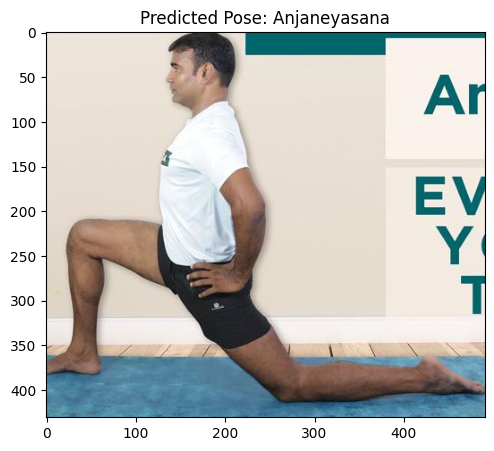

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

# Load the trained model from the .h5 file
model = tf.keras.models.load_model('my_model_final.h5')

# Define the label mapping dictionary
label_mapping = {
    0: 'Adho Mukha Svanasana',
    1: 'Adho Mukha Vrksasana',
    2: 'Alanasana',
    3: 'Anjaneyasana',
    4: 'Ardha Chandrasana',
    5: 'Ardha Matsyendrasana',
    6: 'Ardha Navasana',
    7: 'Ardha Pincha Mayurasana',
    8: 'Ashta Chandrasana',
    9: 'Baddha Konasana',
    10: 'Bakasana',
    11: 'Balasana',
    12: 'Bitilasana',
    13: 'Camatkarasana',
    14: 'Dhanurasana',
    15: 'Eka Pada Rajakapotasana',
    16: 'Garudasana',
    17: 'Halasana',
    18: 'Hanumanasana',
    19: 'Malasana',
    20: 'Marjaryasana',
}

# Function to preprocess the input image
def preprocess_image(image_path):
    image = tf.keras.preprocessing.image.load_img(
        image_path, target_size=(224, 224)
    )
    image_array = tf.keras.preprocessing.image.img_to_array(image)
    image_array = np.expand_dims(image_array, axis=0)
    image_array = tf.keras.applications.mobilenet_v3.preprocess_input(image_array)
    return image_array

# Function to predict the pose from a given image path
def predict_pose(image_path):
    # Preprocess the image
    image_array = preprocess_image(image_path)

    # Make predictions
    predictions = model.predict(image_array)

    # Decode the predictions using the label mapping
    predicted_label_numeric = np.argmax(predictions, axis=1)[0]
    predicted_pose = label_mapping.get(predicted_label_numeric, 'Unknown Pose,please input a valid image')

    return predicted_pose

# Prompt the user for an image path
user_input_image_path = input("Enter the path to your image: ")

# Predict the pose for the user-provided image
predicted_pose = predict_pose(user_input_image_path)

# Display the user-provided image and the predicted pose name
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(plt.imread(user_input_image_path))
ax.set_title(f"Predicted Pose: {predicted_pose}")
plt.show()
